In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score


###Model Selection and Training

In [3]:
df=pd.read_csv('../data/data.csv')
print(df.head())

         TransactionId         BatchId       AccountId       SubscriptionId  \
0  TransactionId_76871   BatchId_36123  AccountId_3957   SubscriptionId_887   
1  TransactionId_73770   BatchId_15642  AccountId_4841  SubscriptionId_3829   
2  TransactionId_26203   BatchId_53941  AccountId_4229   SubscriptionId_222   
3    TransactionId_380  BatchId_102363   AccountId_648  SubscriptionId_2185   
4  TransactionId_28195   BatchId_38780  AccountId_4841  SubscriptionId_3829   

        CustomerId CurrencyCode  CountryCode    ProviderId     ProductId  \
0  CustomerId_4406          UGX          256  ProviderId_6  ProductId_10   
1  CustomerId_4406          UGX          256  ProviderId_4   ProductId_6   
2  CustomerId_4683          UGX          256  ProviderId_6   ProductId_1   
3   CustomerId_988          UGX          256  ProviderId_1  ProductId_21   
4   CustomerId_988          UGX          256  ProviderId_4   ProductId_6   

      ProductCategory    ChannelId   Amount  Value  TransactionStart

In [4]:
#  Calculate RFMS Scores
# Convert transaction_date to datetime
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])

# Calculate RFMS Scores
current_date = df['TransactionStartTime'].max()  # Most recent transaction date
rfms_df = df.groupby('CustomerId').agg(
    Recency=('TransactionStartTime', lambda x: (current_date - x.max()).days),
    Frequency=('TransactionId', 'count'),
    Monetary=('Amount', 'sum')
).reset_index()

In [5]:
# For simplicity, let's assume all customers have a satisfaction score of 1
rfms_df['Satisfaction'] = 1  # Placeholder score

# Calculate RFMS Score (you can adjust weights as needed)
rfms_df['RFMS_Score'] = (rfms_df['Recency'] * 0.25 +
                          rfms_df['Frequency'] * 0.25 +
                          rfms_df['Monetary'] * 0.25 +
                          rfms_df['Satisfaction'] * 0.25)  # Adjust weights as needed

In [6]:

#  Establish a Boundary
threshold = rfms_df['RFMS_Score'].median()  # Using median as a threshold

#  Assign Labels
rfms_df['Risk_Label'] = np.where(rfms_df['RFMS_Score'] >= threshold, 'Good', 'Bad')

# Display the DataFrame with RFMS scores and labels
print(rfms_df[['CustomerId', 'Recency', 'Frequency', 'Monetary', 'RFMS_Score', 'Risk_Label']].head())

        CustomerId  Recency  Frequency  Monetary  RFMS_Score Risk_Label
0     CustomerId_1       83          1  -10000.0    -2478.75        Bad
1    CustomerId_10       83          1  -10000.0    -2478.75        Bad
2  CustomerId_1001       89          5   20000.0     5023.75       Good
3  CustomerId_1002       25         11    4225.0     1065.50        Bad
4  CustomerId_1003       11          6   20000.0     5004.50        Bad


In [8]:
#  Define a function to calculate WoE
def calculate_woe(df, target, variable, bins):
    # Create bins
    df['binned'] = pd.cut(df[variable], bins=bins, include_lowest=True)
    
    # Calculate the number of good and bad for each bin
    grouped = df.groupby('binned')[target].agg(['count', 'sum']).reset_index()
    grouped.columns = ['binned', 'total', 'bad']
    
    # Calculate good and bad counts
    grouped['good'] = grouped['total'] - grouped['bad']
    
    # Calculate WoE
    total_good = df[target].value_counts()[0]  # Assuming 0 is 'Good'
    total_bad = df[target].value_counts()[1]   # Assuming 1 is 'Bad'
    
    grouped['woe'] = np.log((grouped['good'] / total_good) / (grouped['bad'] / total_bad))
    
    return grouped[['binned', 'woe']]

In [10]:

# Calculate Recency, Frequency, Monetary
current_date = df['TransactionStartTime'].max()  # Most recent transaction date
rfms_df = df.groupby('CustomerId').agg(
    Recency=('TransactionStartTime', lambda x: (current_date - x.max()).days),
    Frequency=('TransactionId', 'count'),
    Monetary=('Amount', 'sum')
).reset_index()

#  Create a Default Label
# This is just a placeholder; you should replace it with your actual default logic
# For this example, let's assume 30% of users defaulted randomly
np.random.seed(42)  # For reproducibility
rfms_df['Default'] = np.random.choice([0, 1], size=len(rfms_df), p=[0.7, 0.3])

In [11]:
#   WoE Calculation Function
def calculate_woe(df, target, variable, bins):
    df['binned'] = pd.cut(df[variable], bins=bins, include_lowest=True)
    
    # Calculate the number of good and bad for each bin
    grouped = df.groupby('binned')[target].agg(['count', 'sum']).reset_index()
    grouped.columns = ['binned', 'total', 'bad']
    
    grouped['good'] = grouped['total'] - grouped['bad']
    
    total_good = df[target].value_counts().get(0, 0)  # Assuming 0 is 'Good'
    total_bad = df[target].value_counts().get(1, 0)   # Assuming 1 is 'Bad'
    
    # Calculate WoE
    grouped['woe'] = np.log((grouped['good'] / total_good) / (grouped['bad'] / total_bad))
    
    return grouped[['binned', 'woe']]

In [12]:

#  Define bins for Recency
recency_bins = [0, 30, 60, 90, 120, 180, 365]  # Example bins

#  Calculate WoE for Recency
woe_recency = calculate_woe(rfms_df, 'Default', 'Recency', recency_bins)

#   Merge WoE back into the original DataFrame
rfms_df = rfms_df.merge(woe_recency, on='binned', how='left')

#  Replace the original variable with WoE values
rfms_df['Recency_WoE'] = rfms_df['woe']

#  Calculate RFMS Score
rfms_df['RFMS_Score'] = (rfms_df['Recency'] * 0.25 +
                          rfms_df['Frequency'] * 0.25 +
                          rfms_df['Monetary'] * 0.25)  # Adjust weights as necessary

#   Assign Risk Labels
threshold = rfms_df['RFMS_Score'].median()  # Using median as a threshold
rfms_df['Risk_Label'] = np.where(rfms_df['RFMS_Score'] >= threshold, 'Good', 'Bad')

# Display the final DataFrame with relevant columns
print(rfms_df[['CustomerId', 'Recency', 'Frequency', 'Monetary', 'RFMS_Score', 'Risk_Label', 'Recency_WoE']].head())

        CustomerId  Recency  Frequency  Monetary  RFMS_Score Risk_Label  \
0     CustomerId_1       83          1  -10000.0    -2479.00        Bad   
1    CustomerId_10       83          1  -10000.0    -2479.00        Bad   
2  CustomerId_1001       89          5   20000.0     5023.50       Good   
3  CustomerId_1002       25         11    4225.0     1065.25        Bad   
4  CustomerId_1003       11          6   20000.0     5004.25        Bad   

   Recency_WoE  
0    -0.063762  
1    -0.063762  
2    -0.063762  
3     0.030161  
4     0.030161  


C:\Users\Tesfaye\AppData\Local\Temp\ipykernel_22992\971133610.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('binned')[target].agg(['count', 'sum']).reset_index()


###Split the Data

In [13]:
# Assuming rfms_df contains the relevant features and target variable
# Ensure to include the target variable 'Default' and features for modeling
features = ['Recency_WoE', 'Frequency', 'Monetary', 'RFMS_Score']  # Adjust as necessary
target = 'Default'

In [15]:

#  Split the Data
X =rfms_df[features]  # Features
y = rfms_df[target]    # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Select a Model
model = RandomForestClassifier(random_state=42)

#  Train the Model
model.fit(X_train, y_train)

#  Evaluate the Model
y_pred = model.predict(X_test)

In [16]:

# Print evaluation metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

Confusion Matrix:
[[422 104]
 [186  37]]

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.80      0.74       526
           1       0.26      0.17      0.20       223

    accuracy                           0.61       749
   macro avg       0.48      0.48      0.47       749
weighted avg       0.57      0.61      0.58       749


Accuracy Score: 0.6128170894526035


###Explanation of the Code
Loading Data: The dataset is loaded, assuming it contains the necessary features and target variable.
Splitting the Data:
Features and Target: The features used for modeling are specified, along with the target variable (Default).
train_test_split: The data is split into training and testing sets with 20% of the data reserved for testing. The random_state parameter ensures reproducibility.
Selecting a Model: In this example, a Random Forest classifier is chosen. You can select other models (e.g., Logistic Regression, XGBoost) based on your needs.
Training the Model: The model is trained using the training set.
Evaluating the Model:
Prediction: The model predicts outcomes on the test set.
Metrics: A confusion matrix, classification report, and accuracy score are printed to evaluate the model's performance.

###Choose Models

In [18]:

#   Choose Models
# Logistic Regression
logistic_model = LogisticRegression(random_state=42)

# Random Forest
random_forest_model = RandomForestClassifier(random_state=42)

#  Train Both Models
# Train Logistic Regression
logistic_model.fit(X_train, y_train)

# Train Random Forest
random_forest_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [19]:

#  Evaluate Both Models
# Predictions
y_pred_logistic = logistic_model.predict(X_test)
y_pred_random_forest = random_forest_model.predict(X_test)

In [20]:

# Logistic Regression Evaluation
print("Logistic Regression:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logistic))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logistic))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred_logistic))

# Random Forest Evaluation
print("\nRandom Forest:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_random_forest))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_random_forest))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred_random_forest))

Logistic Regression:
Confusion Matrix:
[[526   0]
 [223   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.83       526
           1       0.00      0.00      0.00       223

    accuracy                           0.70       749
   macro avg       0.35      0.50      0.41       749
weighted avg       0.49      0.70      0.58       749


Accuracy Score: 0.7022696929238985

Random Forest:
Confusion Matrix:
[[422 104]
 [186  37]]

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.80      0.74       526
           1       0.26      0.17      0.20       223

    accuracy                           0.61       749
   macro avg       0.48      0.48      0.47       749
weighted avg       0.57      0.61      0.58       749


Accuracy Score: 0.6128170894526035


c:\Users\Tesfaye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tesfaye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tesfaye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

###Explanation of the Code
Loading Data: The dataset is loaded, and it is assumed that it contains the necessary features and target variable.
Splitting the Data:
The features (Recency_WoE, Frequency, Monetary, RFMS_Score) and target variable (Default) are specified.
The dataset is split into training and testing sets with 20% reserved for testing.
Choosing Models:
Logistic Regression: A linear model for binary classification.
Random Forest: An ensemble model that builds multiple decision trees.
Training Both Models: Both models are trained on the training dataset.
Evaluating Both Models:
Predictions are made for both models on the test set.
A confusion matrix, classification report, and accuracy score are printed for each model to assess performance.

###Train the Models

In [21]:

#  Train Both Models
# Train Logistic Regression
logistic_model.fit(X_train, y_train)

# Train Random Forest
random_forest_model.fit(X_train, y_train)

# Evaluate Both Models
# Predictions
y_pred_logistic = logistic_model.predict(X_test)
y_pred_random_forest = random_forest_model.predict(X_test)

# Logistic Regression Evaluation
print("Logistic Regression:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logistic))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logistic))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred_logistic))

# Random Forest Evaluation
print("\nRandom Forest:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_random_forest))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_random_forest))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred_random_forest))

Logistic Regression:
Confusion Matrix:
[[526   0]
 [223   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.83       526
           1       0.00      0.00      0.00       223

    accuracy                           0.70       749
   macro avg       0.35      0.50      0.41       749
weighted avg       0.49      0.70      0.58       749


Accuracy Score: 0.7022696929238985

Random Forest:
Confusion Matrix:
[[422 104]
 [186  37]]

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.80      0.74       526
           1       0.26      0.17      0.20       223

    accuracy                           0.61       749
   macro avg       0.48      0.48      0.47       749
weighted avg       0.57      0.61      0.58       749


Accuracy Score: 0.6128170894526035


c:\Users\Tesfaye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tesfaye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tesfaye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

###Explanation of the Training Steps
Model Selection: Two models are chosen: Logistic Regression and Random Forest.
Training the Models:
fit() Method: Each model uses the fit() method to train on the training data (X_train and y_train).
This step involves adjusting model parameters based on the training data to learn the underlying patterns.

###HyperParameter Tuning with Grid Search

In [23]:

# Define the model
logistic_model = LogisticRegression(random_state=42)
random_forest_model = RandomForestClassifier(random_state=42)

# Grid Search for Logistic Regression
logistic_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'saga']  # Solvers for optimization
}

grid_search_logistic = GridSearchCV(estimator=logistic_model,
                                     param_grid=logistic_param_grid,
                                     scoring='accuracy',
                                     cv=5,   # 5-fold cross-validation
                                     verbose=1)

grid_search_logistic.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\Tesfaye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Tesfaye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Tesfaye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Tesfaye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Tesfaye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which 

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'solver': ['liblinear', 'saga']},
             scoring='accuracy', verbose=1)

In [24]:
# Best parameters and score for Logistic Regression
print("Best parameters for Logistic Regression:", grid_search_logistic.best_params_)
print("Best cross-validation score for Logistic Regression:", grid_search_logistic.best_score_)

# Grid Search for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
}

Best parameters for Logistic Regression: {'C': 0.01, 'solver': 'liblinear'}
Best cross-validation score for Logistic Regression: 0.7009681687986108


In [25]:

grid_search_rf = GridSearchCV(estimator=random_forest_model,
                               param_grid=rf_param_grid,
                               scoring='accuracy',
                               cv=5,   # 5-fold cross-validation
                               verbose=1)

grid_search_rf.fit(X_train, y_train)

# Best parameters and score for Random Forest
print("Best parameters for Random Forest:", grid_search_rf.best_params_)
print("Best cross-validation score for Random Forest:", grid_search_rf.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation score for Random Forest: 0.6969609326581091


###Grid Search exhaustively searches through a specified parameter grid to find the best combination of hyperparameters.

###Hyperparameter tuning with random search

In [27]:

# Random Search for Logistic Regression
logistic_param_dist = {
    'C': np.logspace(-3, 3, 7),  # Regularization strength
    'solver': ['liblinear', 'saga']
}

random_search_logistic = RandomizedSearchCV(estimator=logistic_model,
                                             param_distributions=logistic_param_dist,
                                             scoring='accuracy',
                                             n_iter=10,  # Number of parameter settings sampled
                                             cv=5,
                                             verbose=1,
                                             random_state=42)

random_search_logistic.fit(X_train, y_train)

# Best parameters and score for Logistic Regression
print("Best parameters for Logistic Regression (Random Search):", random_search_logistic.best_params_)
print("Best cross-validation score for Logistic Regression (Random Search):", random_search_logistic.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\Tesfaye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Tesfaye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Tesfaye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Tesfaye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Tesfaye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which 

Best parameters for Logistic Regression (Random Search): {'solver': 'liblinear', 'C': np.float64(0.001)}
Best cross-validation score for Logistic Regression (Random Search): 0.7009681687986108


In [28]:

# Random Search for Random Forest
rf_param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

random_search_rf = RandomizedSearchCV(estimator=random_forest_model,
                                       param_distributions=rf_param_dist,
                                       scoring='accuracy',
                                       n_iter=10,
                                       cv=5,
                                       verbose=1,
                                       random_state=42)

random_search_rf.fit(X_train, y_train)

# Best parameters and score for Random Forest
print("Best parameters for Random Forest (Random Search):", random_search_rf.best_params_)
print("Best cross-validation score for Random Forest (Random Search):", random_search_rf.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for Random Forest (Random Search): {'n_estimators': 200, 'min_samples_split': 10, 'max_depth': 10}
Best cross-validation score for Random Forest (Random Search): 0.6969609326581091


###Explanation of the Code
Grid Search:
The GridSearchCV class is used to perform an exhaustive search over the specified hyperparameters.
The param_grid argument specifies the hyperparameters and their respective values to search.
Cross-validation (cv=5) is used to evaluate the models' performance with 5-fold splitting.
Random Search:
The RandomizedSearchCV class samples a specified number of hyperparameter combinations instead of exhaustively searching all options.
The param_distributions argument specifies the distributions and ranges of hyperparameters to sample from.
It also uses cross-validation for performance evaluation.

###Model Evaluation

###Accuracy

In [30]:

# Assuming grid_search_logistic and grid_search_rf contain the best models
best_logistic_model = grid_search_logistic.best_estimator_
best_random_forest_model = grid_search_rf.best_estimator_

#   Make predictions on the test set
y_pred_logistic = best_logistic_model.predict(X_test)
y_pred_random_forest = best_random_forest_model.predict(X_test)

In [31]:

#  Calculate accuracy for both models
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
accuracy_random_forest = accuracy_score(y_test, y_pred_random_forest)

#   Print accuracy for both models
print("Logistic Regression Accuracy:", accuracy_logistic)
print("Random Forest Accuracy:", accuracy_random_forest)

Logistic Regression Accuracy: 0.7022696929238985
Random Forest Accuracy: 0.6929238985313751


In [32]:

# Confusion Matrix and Classification Report
print("\nLogistic Regression Evaluation:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logistic))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logistic))


Logistic Regression Evaluation:
Confusion Matrix:
[[526   0]
 [223   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.83       526
           1       0.00      0.00      0.00       223

    accuracy                           0.70       749
   macro avg       0.35      0.50      0.41       749
weighted avg       0.49      0.70      0.58       749



c:\Users\Tesfaye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tesfaye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tesfaye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [33]:

print("\nRandom Forest Evaluation:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_random_forest))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_random_forest))


Random Forest Evaluation:
Confusion Matrix:
[[515  11]
 [219   4]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.98      0.82       526
           1       0.27      0.02      0.03       223

    accuracy                           0.69       749
   macro avg       0.48      0.50      0.43       749
weighted avg       0.57      0.69      0.58       749



###Explanation of the Code
Best Estimators: The best models for both Logistic Regression and Random Forest are obtained from the results of the hyperparameter tuning process (grid_search_logistic and grid_search_rf).
Making Predictions: Predictions are made on the test set for both models using the predict() method.
Calculating Accuracy: The accuracy is computed using accuracy_score(), which compares the true labels (y_test) with the predicted labels.
Displaying Evaluation Metrics:
Confusion Matrix: Displays the number of true positives, true negatives, false positives, and false negatives.
Classification Report: Provides precision, recall, F1-score, and support for each class.

###Precision

In [35]:

#  Calculate precision for both models
precision_logistic = precision_score(y_test, y_pred_logistic)
precision_random_forest = precision_score(y_test, y_pred_random_forest)

#  Print precision for both models
print("Logistic Regression Precision:", precision_logistic)
print("Random Forest Precision:", precision_random_forest)

Logistic Regression Precision: 0.0
Random Forest Precision: 0.26666666666666666


c:\Users\Tesfaye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [36]:

 
print("\nLogistic Regression Evaluation:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logistic))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logistic))


Logistic Regression Evaluation:
Confusion Matrix:
[[526   0]
 [223   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.83       526
           1       0.00      0.00      0.00       223

    accuracy                           0.70       749
   macro avg       0.35      0.50      0.41       749
weighted avg       0.49      0.70      0.58       749



c:\Users\Tesfaye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tesfaye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tesfaye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [37]:
print("\nRandom Forest Evaluation:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_random_forest))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_random_forest))


Random Forest Evaluation:
Confusion Matrix:
[[515  11]
 [219   4]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.98      0.82       526
           1       0.27      0.02      0.03       223

    accuracy                           0.69       749
   macro avg       0.48      0.50      0.43       749
weighted avg       0.57      0.69      0.58       749



###Recall

In [38]:
from sklearn.metrics import recall_score

# Step 1: Calculate recall for both models
recall_logistic = recall_score(y_test, y_pred_logistic)
recall_random_forest = recall_score(y_test, y_pred_random_forest)

# Step 2: Print recall for both models
print("Logistic Regression Recall:", recall_logistic)
print("Random Forest Recall:", recall_random_forest)

Logistic Regression Recall: 0.0
Random Forest Recall: 0.017937219730941704


In [39]:

 
print("\nLogistic Regression Evaluation:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logistic))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logistic))

print("\nRandom Forest Evaluation:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_random_forest))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_random_forest))


Logistic Regression Evaluation:
Confusion Matrix:
[[526   0]
 [223   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.83       526
           1       0.00      0.00      0.00       223

    accuracy                           0.70       749
   macro avg       0.35      0.50      0.41       749
weighted avg       0.49      0.70      0.58       749


Random Forest Evaluation:
Confusion Matrix:
[[515  11]
 [219   4]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.98      0.82       526
           1       0.27      0.02      0.03       223

    accuracy                           0.69       749
   macro avg       0.48      0.50      0.43       749
weighted avg       0.57      0.69      0.58       749



c:\Users\Tesfaye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tesfaye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tesfaye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

###Explanation of the Code
Calculating Recall:
Use recall_score() to compute the recall for each model based on the true labels (y_test) and the predicted labels (y_pred_logistic and y_pred_random_forest).
Printing Recall:
The recall values for both models are printed to assess their performance in identifying positive cases correctly.
Confusion Matrix and Classification Report:
The confusion matrix and classification report provide additional context on the models' performance, including precision, recall, and F1-score.

In [40]:
from sklearn.metrics import f1_score

#  Calculate F1 Score for both models
f1_logistic = f1_score(y_test, y_pred_logistic)
f1_random_forest = f1_score(y_test, y_pred_random_forest)

#  Print F1 Score for both models
print("Logistic Regression F1 Score:", f1_logistic)
print("Random Forest F1 Score:", f1_random_forest)

 
print("\nLogistic Regression Evaluation:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logistic))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logistic))

print("\nRandom Forest Evaluation:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_random_forest))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_random_forest))

Logistic Regression F1 Score: 0.0
Random Forest F1 Score: 0.03361344537815126

Logistic Regression Evaluation:
Confusion Matrix:
[[526   0]
 [223   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      1.00      0.83       526
           1       0.00      0.00      0.00       223

    accuracy                           0.70       749
   macro avg       0.35      0.50      0.41       749
weighted avg       0.49      0.70      0.58       749


Random Forest Evaluation:
Confusion Matrix:
[[515  11]
 [219   4]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.98      0.82       526
           1       0.27      0.02      0.03       223

    accuracy                           0.69       749
   macro avg       0.48      0.50      0.43       749
weighted avg       0.57      0.69      0.58       749



c:\Users\Tesfaye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tesfaye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Tesfaye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

###Explanation of the Code
Calculating F1 Score:
Use f1_score() to compute the F1 Score for each model based on the true labels (y_test) and the predicted labels (y_pred_logistic and y_pred_random_forest).
Printing F1 Score:
The F1 Scores for both models are printed to assess their overall balance between precision and recall.
Confusion Matrix and Classification Report:
Including the confusion matrix and classification report again provides context on how well each model is performing in terms of precision, recall, and overall accuracy.

###ROC-AUC

In [41]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

#  Get the predicted probabilities for the positive class
y_prob_logistic = best_logistic_model.predict_proba(X_test)[:, 1]
y_prob_random_forest = best_random_forest_model.predict_proba(X_test)[:, 1]

#  Calculate ROC-AUC for both models
roc_auc_logistic = roc_auc_score(y_test, y_prob_logistic)
roc_auc_random_forest = roc_auc_score(y_test, y_prob_random_forest)

In [42]:

#   Print ROC-AUC for both models
print("Logistic Regression ROC-AUC:", roc_auc_logistic)
print("Random Forest ROC-AUC:", roc_auc_random_forest)

#  Plot ROC Curve for both models
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_prob_logistic)
fpr_random_forest, tpr_random_forest, _ = roc_curve(y_test, y_prob_random_forest)

Logistic Regression ROC-AUC: 0.5015047144878856
Random Forest ROC-AUC: 0.5077793312758956


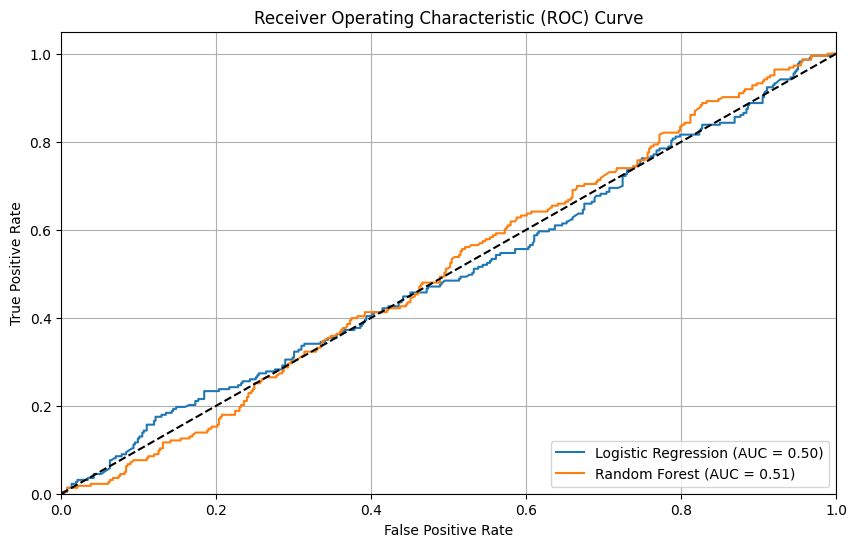

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(fpr_logistic, tpr_logistic, label='Logistic Regression (AUC = {:.2f})'.format(roc_auc_logistic))
plt.plot(fpr_random_forest, tpr_random_forest, label='Random Forest (AUC = {:.2f})'.format(roc_auc_random_forest))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

###Explanation of the Code
Predicted Probabilities:
Use predict_proba() to obtain the predicted probabilities of the positive class. This is necessary for calculating the ROC-AUC.
Calculating ROC-AUC:
Use roc_auc_score() to compute the ROC-AUC for both models based on the true labels (y_test) and the predicted probabilities.
Printing ROC-AUC:
The ROC-AUC values for both models are printed to assess their discriminatory power.
Plotting ROC Curve:
The ROC curve is plotted for both models using roc_curve(), which provides the false positive rates and true positive rates needed for the plot.

In [44]:
import joblib

# Save models
joblib.dump(best_logistic_model, 'logistic_model.pkl')
joblib.dump(best_random_forest_model, 'random_forest_model.pkl')

['random_forest_model.pkl']